<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W3/ungraded_labs/C4_W3_Lab_1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [5]:
#!pip install tensorflow==2.5.0

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2.7.0


In [18]:
def plot_history(history, start_epoch=None, end_epoch=None):
    if start_epoch is None:
        start_epoch = 0
    if end_epoch is None:
        end_epoch = len(history.history['loss'])       
            
    max_epoch = min(len(history.history['loss']), end_epoch)
    loss = history.history['loss'][start_epoch:end_epoch]
    val_loss = history.history['val_loss'][start_epoch:end_epoch]
    
    plt.figure(figsize=(8, 5))
    epochs = range(start_epoch, max_epoch)
    if max_epoch <= 20:
        xticks = range(start_epoch, max_epoch)
    else:
        xticks = range(start_epoch, max_epoch, (max_epoch-1)//20+10)

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(xticks)
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()
    
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

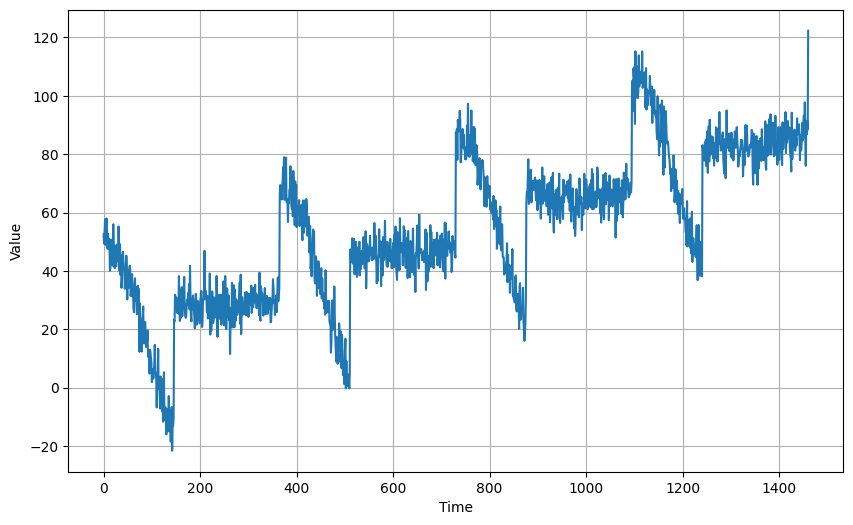

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
val_set = windowed_dataset(x_valid, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 161ms/step - loss: 145.5242 - mae: 146.0242 - val_loss: 187.7570 - val_mae: 188.2570 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 1s 55ms/step - loss: 145.1239 - mae: 145.6239 - val_loss: 187.1985 - val_mae: 187.6985 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 1s 56ms/step - loss: 144.4827 - mae: 144.9827 - val_loss: 186.4575 - val_mae: 186.9575 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 1s 55ms/step - loss: 143.6798 - mae: 144.1798 - val_loss: 185.5767 - val_mae: 186.0767 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 1s 55ms/step - loss: 142.7446 - mae: 143.2446 - val_loss: 184.5653 - val_mae: 185.0653 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 1s 55ms/step - loss: 141.6799 - mae: 142.1795 - val_loss: 183.4194 - val_mae: 183.9194 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 1s 57ms/step - los

Epoch 55/100
8/8 [==============================] - 1s 56ms/step - loss: 6.3967 - mae: 6.8786 - val_loss: 5.2264 - val_mae: 5.7057 - lr: 5.0119e-06
Epoch 56/100
8/8 [==============================] - 1s 55ms/step - loss: 6.2427 - mae: 6.7246 - val_loss: 8.1711 - val_mae: 8.6567 - lr: 5.6234e-06
Epoch 57/100
8/8 [==============================] - 1s 56ms/step - loss: 6.3695 - mae: 6.8510 - val_loss: 5.6431 - val_mae: 6.1256 - lr: 6.3096e-06
Epoch 58/100
8/8 [==============================] - 1s 56ms/step - loss: 5.9563 - mae: 6.4346 - val_loss: 5.6041 - val_mae: 6.0812 - lr: 7.0795e-06
Epoch 59/100
8/8 [==============================] - 1s 65ms/step - loss: 6.1005 - mae: 6.5822 - val_loss: 5.4698 - val_mae: 5.9415 - lr: 7.9433e-06
Epoch 60/100
8/8 [==============================] - 1s 56ms/step - loss: 5.9375 - mae: 6.4209 - val_loss: 6.2199 - val_mae: 6.7037 - lr: 8.9125e-06
Epoch 61/100
8/8 [==============================] - 1s 65ms/step - loss: 6.0237 - mae: 6.5010 - val_loss: 6.2639

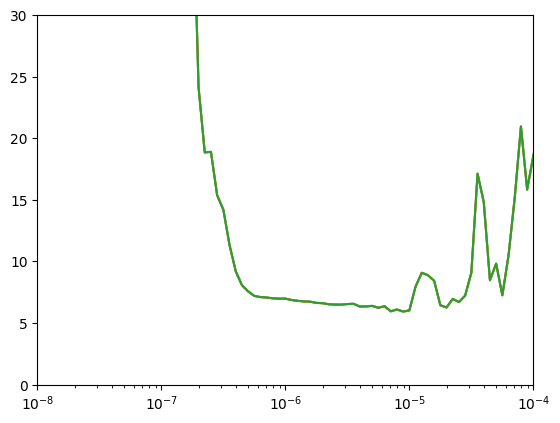

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])
plt.show()

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
val_set = windowed_dataset(x_valid, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400, validation_data=val_set)

Epoch 1/400
8/8 [==============================] - 2s 103ms/step - loss: 72.0323 - mae: 72.5316 - val_loss: 57.7941 - val_mae: 58.2941
Epoch 2/400
8/8 [==============================] - 1s 55ms/step - loss: 19.2475 - mae: 19.7415 - val_loss: 13.9963 - val_mae: 14.4918
Epoch 3/400
8/8 [==============================] - 1s 61ms/step - loss: 19.1910 - mae: 19.6875 - val_loss: 48.2209 - val_mae: 48.7209
Epoch 4/400
8/8 [==============================] - 1s 55ms/step - loss: 16.3122 - mae: 16.8063 - val_loss: 41.7270 - val_mae: 42.2270
Epoch 5/400
8/8 [==============================] - 1s 56ms/step - loss: 14.5794 - mae: 15.0715 - val_loss: 26.8618 - val_mae: 27.3594
Epoch 6/400
8/8 [==============================] - 1s 56ms/step - loss: 12.4397 - mae: 12.9311 - val_loss: 29.8374 - val_mae: 30.3374
Epoch 7/400
8/8 [==============================] - 1s 59ms/step - loss: 9.8272 - mae: 10.3176 - val_loss: 11.1053 - val_mae: 11.6007
Epoch 8/400
8/8 [==============================] - 1s 59ms/ste

8/8 [==============================] - 1s 60ms/step - loss: 6.0106 - mae: 6.4911 - val_loss: 12.3046 - val_mae: 12.7961
Epoch 63/400
8/8 [==============================] - 1s 56ms/step - loss: 5.5833 - mae: 6.0671 - val_loss: 8.2391 - val_mae: 8.7266
Epoch 64/400
8/8 [==============================] - 1s 71ms/step - loss: 6.0714 - mae: 6.5543 - val_loss: 9.6429 - val_mae: 10.1302
Epoch 65/400
8/8 [==============================] - 1s 63ms/step - loss: 7.5444 - mae: 8.0306 - val_loss: 28.2556 - val_mae: 28.7556
Epoch 66/400
8/8 [==============================] - 1s 66ms/step - loss: 9.7643 - mae: 10.2487 - val_loss: 9.6362 - val_mae: 10.1261
Epoch 67/400
8/8 [==============================] - 1s 55ms/step - loss: 8.1407 - mae: 8.6274 - val_loss: 19.6683 - val_mae: 20.1634
Epoch 68/400
8/8 [==============================] - 1s 55ms/step - loss: 5.6697 - mae: 6.1536 - val_loss: 11.1763 - val_mae: 11.6685
Epoch 69/400
8/8 [==============================] - 1s 64ms/step - loss: 5.9181 - mae

8/8 [==============================] - 1s 55ms/step - loss: 5.6021 - mae: 6.0804 - val_loss: 10.4145 - val_mae: 10.9059
Epoch 125/400
8/8 [==============================] - 1s 54ms/step - loss: 5.6533 - mae: 6.1340 - val_loss: 8.5223 - val_mae: 9.0122
Epoch 126/400
8/8 [==============================] - 1s 62ms/step - loss: 5.3251 - mae: 5.8053 - val_loss: 7.4180 - val_mae: 7.8961
Epoch 127/400
8/8 [==============================] - 1s 59ms/step - loss: 4.8469 - mae: 5.3270 - val_loss: 6.7552 - val_mae: 7.2350
Epoch 128/400
8/8 [==============================] - 1s 56ms/step - loss: 4.9479 - mae: 5.4285 - val_loss: 6.7616 - val_mae: 7.2393
Epoch 129/400
8/8 [==============================] - 1s 60ms/step - loss: 5.1549 - mae: 5.6387 - val_loss: 11.7822 - val_mae: 12.2778
Epoch 130/400
8/8 [==============================] - 1s 78ms/step - loss: 5.5573 - mae: 6.0395 - val_loss: 6.3232 - val_mae: 6.8043
Epoch 131/400
8/8 [==============================] - 1s 55ms/step - loss: 5.8726 - mae

Epoch 186/400
8/8 [==============================] - 1s 56ms/step - loss: 4.5231 - mae: 4.9978 - val_loss: 6.2234 - val_mae: 6.7058
Epoch 187/400
8/8 [==============================] - 1s 57ms/step - loss: 4.3421 - mae: 4.8147 - val_loss: 5.8125 - val_mae: 6.2930
Epoch 188/400
8/8 [==============================] - 1s 65ms/step - loss: 4.4433 - mae: 4.9181 - val_loss: 5.7867 - val_mae: 6.2632
Epoch 189/400
8/8 [==============================] - 1s 55ms/step - loss: 4.4286 - mae: 4.8992 - val_loss: 5.6037 - val_mae: 6.0757
Epoch 190/400
8/8 [==============================] - 1s 56ms/step - loss: 4.7369 - mae: 5.2135 - val_loss: 8.5617 - val_mae: 9.0492
Epoch 191/400
8/8 [==============================] - 1s 56ms/step - loss: 5.5348 - mae: 6.0156 - val_loss: 6.7024 - val_mae: 7.1876
Epoch 192/400
8/8 [==============================] - 1s 56ms/step - loss: 5.4851 - mae: 5.9654 - val_loss: 7.4786 - val_mae: 7.9601
Epoch 193/400
8/8 [==============================] - 1s 59ms/step - loss: 4.

8/8 [==============================] - 1s 55ms/step - loss: 4.9886 - mae: 5.4684 - val_loss: 6.1640 - val_mae: 6.6488
Epoch 249/400
8/8 [==============================] - 1s 55ms/step - loss: 5.0120 - mae: 5.4936 - val_loss: 6.7910 - val_mae: 7.2731
Epoch 250/400
8/8 [==============================] - 1s 55ms/step - loss: 5.4675 - mae: 5.9482 - val_loss: 8.5347 - val_mae: 9.0264
Epoch 251/400
8/8 [==============================] - 1s 56ms/step - loss: 4.7729 - mae: 5.2495 - val_loss: 6.5107 - val_mae: 6.9957
Epoch 252/400
8/8 [==============================] - 1s 63ms/step - loss: 4.5277 - mae: 5.0056 - val_loss: 6.0880 - val_mae: 6.5648
Epoch 253/400
8/8 [==============================] - 1s 55ms/step - loss: 4.4304 - mae: 4.9100 - val_loss: 5.8117 - val_mae: 6.2879
Epoch 254/400
8/8 [==============================] - 1s 65ms/step - loss: 4.3621 - mae: 4.8364 - val_loss: 5.6749 - val_mae: 6.1569
Epoch 255/400
8/8 [==============================] - 1s 74ms/step - loss: 4.3057 - mae: 4.

8/8 [==============================] - 1s 56ms/step - loss: 4.2314 - mae: 4.7030 - val_loss: 5.7788 - val_mae: 6.2556
Epoch 311/400
8/8 [==============================] - 1s 57ms/step - loss: 4.1637 - mae: 4.6365 - val_loss: 5.6958 - val_mae: 6.1757
Epoch 312/400
8/8 [==============================] - 1s 56ms/step - loss: 4.7618 - mae: 5.2364 - val_loss: 5.6849 - val_mae: 6.1633
Epoch 313/400
8/8 [==============================] - 1s 57ms/step - loss: 4.8541 - mae: 5.3328 - val_loss: 5.6948 - val_mae: 6.1705
Epoch 314/400
8/8 [==============================] - 1s 56ms/step - loss: 5.7575 - mae: 6.2344 - val_loss: 7.1268 - val_mae: 7.6109
Epoch 315/400
8/8 [==============================] - 1s 61ms/step - loss: 5.4612 - mae: 5.9452 - val_loss: 6.4331 - val_mae: 6.9217
Epoch 316/400
8/8 [==============================] - 1s 61ms/step - loss: 4.7731 - mae: 5.2509 - val_loss: 6.4902 - val_mae: 6.9767
Epoch 317/400
8/8 [==============================] - 1s 67ms/step - loss: 4.9460 - mae: 5.

8/8 [==============================] - 1s 56ms/step - loss: 4.1134 - mae: 4.5864 - val_loss: 5.6978 - val_mae: 6.1751
Epoch 373/400
8/8 [==============================] - 1s 56ms/step - loss: 4.2279 - mae: 4.7021 - val_loss: 6.1303 - val_mae: 6.6111
Epoch 374/400
8/8 [==============================] - 1s 56ms/step - loss: 4.1050 - mae: 4.5808 - val_loss: 6.9255 - val_mae: 7.4037
Epoch 375/400
8/8 [==============================] - 1s 56ms/step - loss: 4.5479 - mae: 5.0253 - val_loss: 5.5933 - val_mae: 6.0715
Epoch 376/400
8/8 [==============================] - 1s 55ms/step - loss: 4.1249 - mae: 4.5976 - val_loss: 6.1281 - val_mae: 6.6145
Epoch 377/400
8/8 [==============================] - 1s 56ms/step - loss: 4.3695 - mae: 4.8409 - val_loss: 6.2645 - val_mae: 6.7493
Epoch 378/400
8/8 [==============================] - 1s 56ms/step - loss: 4.6446 - mae: 5.1170 - val_loss: 6.2969 - val_mae: 6.7838
Epoch 379/400
8/8 [==============================] - 1s 56ms/step - loss: 4.3392 - mae: 4.

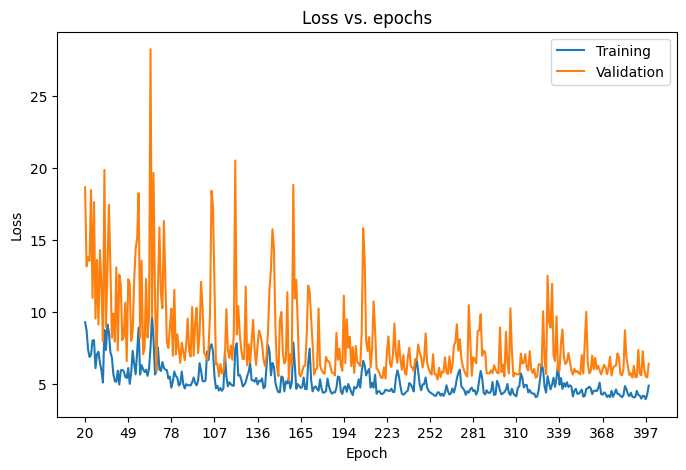

In [21]:
plot_history(history, start_epoch=20)

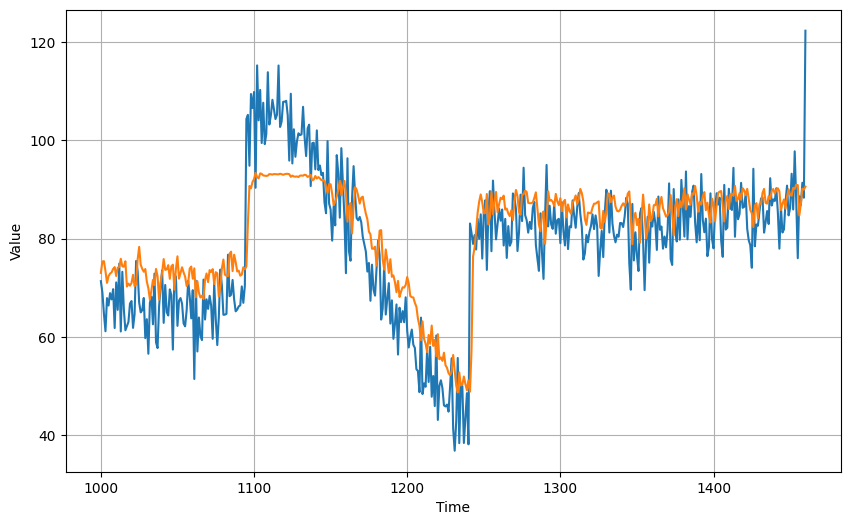

In [19]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.show()

In [22]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

73.21446
6.8985605


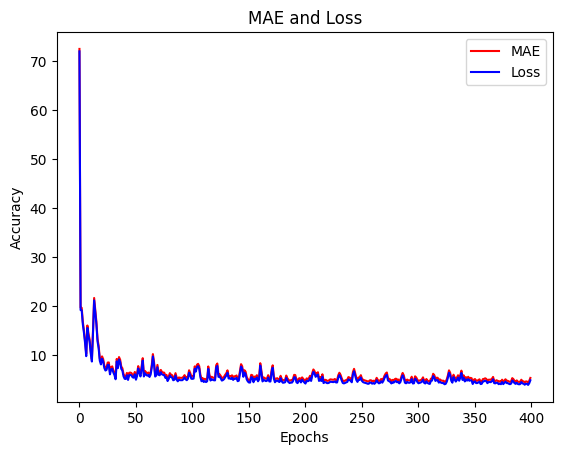

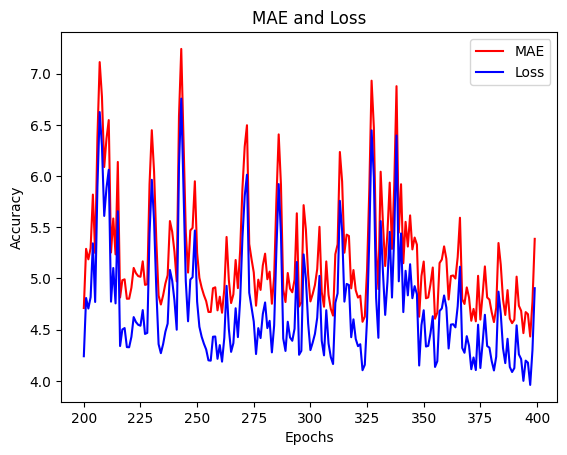

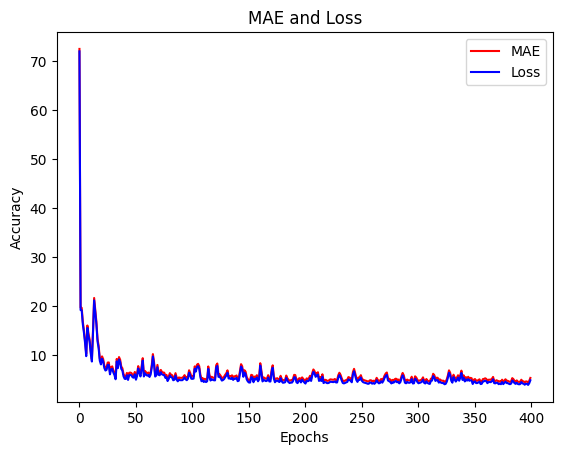

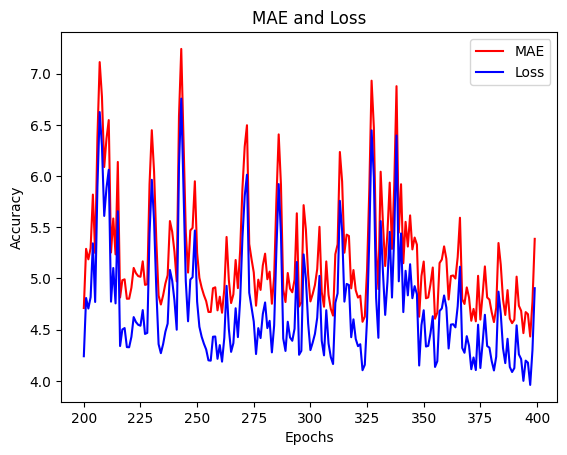

<Figure size 640x480 with 0 Axes>

In [24]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()
plt.show()